# DataLab Cup 4 : Reverse Image Caption

Team name: 卍閃傲o剎帝卍

Team members:

    106024510 陳俊穎 Chen, Chun Ying

    106024513 曾奕齊 Tseng, Yi-Chi

    106024519 吳亦振 Wu, Yi-Chen

    106024509 曾立豪 Zeng, Li Hao

Environment :

- OS : win10
- CPU : intel i5 - 8500
- RAM : 16GB
- GPU : 1050ti

The final report should contain following points:

- Pick 5 descriptions from testing data and generate 5 images with different z respectively.

- The models you tried during competition. Briefly descript the main idea of this model and why you chose this model.

- List the experiment you did. For example, the hyper-parameters tuning, architecture tuning, optimizer tuning and so on.

- Other things worth to mention. For example, how to pre-train the model.

In [1]:
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf

import scipy
from scipy.io import loadmat
import re

import string
import imageio
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import nltk
from utils import*

from matplotlib.pyplot import figure
from PIL import Image

import cv2
import warnings
warnings.filterwarnings('ignore')

C:\Users\a0972\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1. Data preprocessing of  image and captions

In [2]:
dictionary_path = 'D:/DL4/dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))

In [3]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
        ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    for i in range(padding):
        tokens.append('<PAD>')
        line = [
          word2Id_dict[tokens[k]]
          if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
          for k in range(len(tokens))
        ]

    return line

In [4]:
data_path = 'D:/DL4/dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample

#### We add mismatch pair data ( wrong image ) and shuffle the training data set. We only use 1 caption per image.

In [5]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_DEPTH = 3
def training_data_generator(caption, true_image_path,wrong_image_path):
    # load in the image according to image path
    trueimagefile = tf.read_file(data_path + true_image_path)
    trueimage = tf.image.decode_image(trueimagefile, channels=3)
    true_float_img = tf.image.convert_image_dtype(trueimage, tf.float32)
    true_float_img.set_shape([None, None, 3])
    trueimage = tf.image.resize_images(true_float_img, size = [IMAGE_HEIGHT, IMAGE_WIDTH])
    trueimage.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
    
    wrongimagefile = tf.read_file(data_path + wrong_image_path)
    wrongimage = tf.image.decode_image(wrongimagefile, channels=3)
    wrong_float_img = tf.image.convert_image_dtype(wrongimage, tf.float32)
    wrong_float_img.set_shape([None, None, 3])
    wrongimage = tf.image.resize_images(wrong_float_img, size = [IMAGE_HEIGHT, IMAGE_WIDTH])
    wrongimage.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
    
    return trueimage, wrongimage, caption

def shuffle_training_set(captions, true_image_path, wrong_image_path):
    indices = [i for i in range(captions.shape[0])]
    random.shuffle(indices)
    new_captions = []
    new_true_image = []
    new_wrong_image = []
    for i in range(len(indices)):
        index = indices[i]
        new_captions.append(captions[index])
        new_true_image.append(true_image_path[index])
        new_wrong_image.append(wrong_image_path[index])
    new_captions = np.asarray(new_captions)
    new_true_image = np.asarray(new_true_image)
    new_wrong_image = np.asarray(new_wrong_image)
    return new_captions, new_true_image, new_wrong_image

def data_iterator(filenames, batch_size, data_generator):
    # Load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    captions = df['Captions'].values
    image_path = df['ImagePath'].values
    caption = []
    true_image_path = []
    wrong_image_path = []
    
    #一張圖只配一個caption
    for i in range(len(captions)):
        caption.append(random.choice(captions[i])) 
    caption = np.asarray(caption)
    
    for i in range(len(captions)):
        wrong_path = []
        wrong_path.extend(image_path[0:i])
        wrong_path.extend(image_path[i + 1:])
        assert len(wrong_path) + 1 == len(image_path)

        true_image_path.append(image_path[i])
        wrong_image_path.append(random.choice(wrong_path))
    
    true_image_path = np.asarray(true_image_path)
    wrong_image_path = np.asarray(wrong_image_path)
    
    caption, true_image_path, wrong_image_path = shuffle_training_set(caption, true_image_path, wrong_image_path)

    # Assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == true_image_path.shape[0]
    
    assert captions.shape[0] == num_training_sample
        
    dataset = tf.data.Dataset.from_tensor_slices((caption, true_image_path, wrong_image_path))
    dataset = dataset.map(data_generator)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    
    iterator = dataset.make_initializable_iterator()
    output_types = dataset.output_types
    output_shapes = dataset.output_shapes
    
    return iterator, output_types, output_shapes

### 2. Models

In [6]:
import math
import numpy as np 
import tensorflow as tf

from tensorflow.python.framework import ops

def my_layer(X, eps=1e-8, offset=0, scale=1):
    if X.get_shape().ndims == 4:
        mean = tf.reduce_mean(X, [0,1,2])
        var = tf.reduce_mean( tf.square(X-mean), [0,1,2] )
        output = tf.nn.batch_normalization(X, mean, var, offset, scale, eps)
    elif X.get_shape().ndims == 2:
        mean = tf.reduce_mean(X, 0)
        var = tf.reduce_mean(tf.square(X-mean), 0)
        output = tf.nn.batch_normalization(X, mean, var, offset, scale, eps)
    else:
        raise NotImplementedError
    return output

def binary_cross_entropy(preds, targets, name=None):
    """Computes binary cross entropy given `preds`.
    For brevity, let `x = `, `z = targets`.  The logistic loss is
    loss(x, z) = - sum_i (x[i] * log(z[i]) + (1 - x[i]) * log(1 - z[i]))
    Args:
    preds: A `Tensor` of type `float32` or `float64`.
    targets: A `Tensor` of the same type and shape as `preds`.
    """
    eps = 1e-12
    with ops.op_scope([preds, targets], name, "bce_loss") as name:
        preds = ops.convert_to_tensor(preds, name="preds")
        targets = ops.convert_to_tensor(targets, name="targets")
        return tf.reduce_mean(-(targets * tf.log(preds + eps) + (1. - targets) * tf.log(1. - preds + eps)))

def conv_cond_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.get_shape()
    y_shapes = y.get_shape()
    return tf.concat(3, [x, y*tf.ones([x_shapes[0], x_shapes[1], x_shapes[2], y_shapes[3]])])

def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')
        
        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())
        
        return conv

def deconv2d(input_, output_shape,k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,name="deconv2d", with_w=False):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_h, output_shape[-1], input_.get_shape()[-1]],initializer=tf.random_normal_initializer(stddev=stddev))
        
        try:
            deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,strides=[1, d_h, d_w, 1])
            
            # Support for verisons of TensorFlow before 0.7.0
        except AttributeError:
            deconv = tf.nn.deconv2d(input_, w, output_shape=output_shape,strides=[1, d_h, d_w, 1])

        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())
        
        if with_w:
            return deconv, w, biases
        else:
            return deconv

def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    shape = input_.get_shape().as_list()
    
    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias

#### Text encoder remain the same as TA code.

In [7]:
class TextEncoder:
    """
    Encode text (a caption) into hidden representation
    input: text (a list of id)
    output: hidden representation of input text in dimention of TEXT_DIM
    """
    def __init__(self, text, hparas, training_phase=True, reuse=False, return_embed=False):
        self.text = text
        self.hparas = hparas
        self.train = training_phase
        self.reuse = reuse
        self._build_model()
    def _build_model(self):
        with tf.variable_scope('rnnftxt', reuse=self.reuse):
            # Word embedding
            word_embed_matrix = tf.get_variable('rnn/wordembed', 
                                                shape=(self.hparas['VOCAB_SIZE'], self.hparas['EMBED_DIM']),
                                                initializer=tf.random_normal_initializer(stddev=0.02),
                                                dtype=tf.float32)
            embedded_word_ids = tf.nn.embedding_lookup(word_embed_matrix, self.text)
            # RNN encoder
            LSTMCell = tf.nn.rnn_cell.LSTMCell(self.hparas['TEXT_DIM'], reuse=self.reuse)
            initial_state = LSTMCell.zero_state(self.hparas['BATCH_SIZE'], dtype=tf.float32)
            rnn_net = tf.nn.dynamic_rnn(cell=LSTMCell, 
                                        inputs=embedded_word_ids, 
                                        initial_state=initial_state, 
                                        dtype=np.float32, time_major=False,
                                        scope='rnn/dynamic')
            self.rnn_net = rnn_net
            self.outputs = rnn_net[0][:, -1, :]

#### We add CNN encoder to help training the text encoder output.

#### Referece : Github ( zsdonghao )

https://github.com/zsdonghao/text-to-image/blob/master/model.py?fbclid=IwAR2h9PtpHzRqcLhWbQ8zkJZ1v8Fms-k3dLd3ix5x3pA6hCVlE5PfJkgq3o0

In [8]:
class cnn_encoder:
        
    def __init__(self, image, training_phase, hparas, reuse):
        self.image = image
        self.text = text
        self.train = training_phase
        self.hparas = hparas
        self.df_dim = 64  # 196 for MSCOCO
        self.t_dim = self.hparas['TEXT_DIM']
        self.reuse = reuse

        self._build_model()
 
    def _build_model(self):

        with tf.variable_scope('cnn_encoder', reuse=self.reuse):

            df_dim = self.df_dim

            h0 = lrelu(conv2d(self.image, df_dim, k_h=4, k_w=4, name='c_h0_conv'))               
            h1 = conv2d(h0, df_dim * 2, k_h=4, k_w=4, name='c_h1_conv')                
            h2 = lrelu(my_layer(h1))


            h3 = conv2d(h2, df_dim * 4, k_h=4, k_w=4, name='c_h3_conv')
            h4 = lrelu(my_layer(h3))


            h5 = conv2d(h4, df_dim * 8, k_h=4, k_w=4, name='c_h5_conv')
            h6 = lrelu(my_layer(h5))


            h7 = tf.contrib.layers.flatten(h6)
            h8 = linear(h7, self.t_dim, 'c_output')

            self.outputs = h8

#### The generator and discriminator are more complecated.

#### Referece : Github ( paarthneekhara )

https://github.com/paarthneekhara/text-to-image/blob/master/model.py  

In [9]:
class Generator:
    def __init__(self, noise_z, text, training_phase, hparas, reuse):
        self.z = noise_z
        self.text = text
        self.train = training_phase
        self.hparas = hparas
        self.gf_dim = 64
        self.reuse = reuse
        self._build_model()

    def _build_model(self):
        with tf.variable_scope('generator', reuse=self.reuse):
            
            s = self.hparas['IMAGE_SIZE'][0]
            s2, s4, s8, s16 = int(s / 2), int(s / 4), int(s / 8), int(s / 16)

            gf_dim = self.gf_dim

            reduced_text_embedding = lrelu(linear(
                self.text, self.hparas['TEXT_DIM'], 'g_embedding'))
            z_concat = tf.concat([self.z, reduced_text_embedding], 1)
            z_ = linear(z_concat, gf_dim * 8 * s16 * s16, 'g_h0_lin')
            h0 = tf.reshape(z_, [-1, s16, s16, gf_dim * 8])
            h0 = tf.nn.relu(my_layer(h0))

            h1 = deconv2d(h0, [self.hparas['BATCH_SIZE'],
                               s8, s8, gf_dim * 4], name='g_h1')
            h1 = tf.nn.relu(my_layer(h1))

            h2 = deconv2d(h1, [self.hparas['BATCH_SIZE'],
                               s4, s4, gf_dim * 2], name='g_h2')
            h2 = tf.nn.relu(my_layer(h2))

            h3 = deconv2d(h2, [self.hparas['BATCH_SIZE'],
                               s2, s2, gf_dim * 1], name='g_h3')
            h3 = tf.nn.relu(my_layer(h3))

            h4 = deconv2d(h3, [self.hparas['BATCH_SIZE'], s, s, 3], name='g_h4')

            self.generator_net = tf.tanh(h4) / 2.0 + 0.5
            self.outputs = tf.tanh(h4) / 2.0 + 0.5

In [10]:
class Discriminator:
    def __init__(self, image, text, training_phase, hparas, reuse):
        self.image = image
        self.text = text
        self.train = training_phase
        self.hparas = hparas
        self.df_dim = 64  # 196 for MSCOCO
        self.reuse = reuse

        self._build_model()

    def _build_model(self):
        with tf.variable_scope('discriminator', reuse=self.reuse):
            df_dim = self.df_dim

            h0 = lrelu(conv2d(
                self.image, df_dim, name='d_h0_conv'))  # 32
            h1 = lrelu(my_layer(conv2d(
                h0, df_dim * 2, name='d_h1_conv')))  # 16
            h2 = lrelu(my_layer(conv2d(
                h1, df_dim * 4, name='d_h2_conv')))  # 8
            h3 = lrelu(my_layer(conv2d(
                h2, df_dim * 8, name='d_h3_conv')))  # 4

            # ADD TEXT EMBEDDING TO THE NETWORK
            reduced_text_embeddings = lrelu(linear(
                self.text, self.hparas['TEXT_DIM'], 'd_embedding'))
            reduced_text_embeddings = tf.expand_dims(reduced_text_embeddings, 1)
            reduced_text_embeddings = tf.expand_dims(reduced_text_embeddings, 2)
            tiled_embeddings = tf.tile(reduced_text_embeddings, [
                                       1, 4, 4, 1], name='tiled_embeddings')

            h3_concat = tf.concat([h3, tiled_embeddings], 3, name='h3_concat')
            h3_new = lrelu(my_layer(conv2d(
                h3_concat, df_dim * 8, 1, 1, 1, 1, name='d_h3_conv_new')))  # 4

            h4 = linear(tf.reshape(
                h3_new, [self.hparas['BATCH_SIZE'], -1]), 1, 'd_h3_lin')

            self.logits = h4
            self.discriminator_net = tf.nn.sigmoid(h4)
            self.outputs = tf.nn.sigmoid(h4)

#### Parameters


- MAX_SEQ_LENGTH : 20
- EMBED_DIM : 300
- VOCAB_SIZE : len(vocab)
- TEXT_DIM : 64 
- RNN_HIDDEN_SIZE : 64
- Z_DIM : 64 
- IMAGE_SIZE : [64, 64, 3] 
- BATCH_SIZE : 25
- LR : 0.002
- DECAY_EVERY' : 50
- LR_DECAY : 0.5
- BETA : 0.5
- N_EPOCH : 300
- N_SAMPLE : num_training_sample
- GP_LAMBDA' : 0.1
- Optimizer : Adam

#### We add gradient panelty  

In [11]:
class GAN:
    def __init__(self, hparas, training_phase, dataset_path, ckpt_path, inference_path, recover=None):
        self.hparas = hparas
        self.train = training_phase
        self.dataset_path = dataset_path # dataPath+'/text2ImgData.pkl'
        self.ckpt_path = ckpt_path
        self.sample_path = 'D:/DL4/samples4'
        self.inference_path = 'D:/DL4/inference4'
        
        self._get_session() # get session
        self._get_train_data_iter() # initialize and get data iterator
        self._input_layer() # define input placeholder
        self._get_inference() # build generator and discriminator
        self._get_loss() # define gan loss
        self._get_var_with_name() # get variables for each part of model
        self._optimize() # define optimizer
        self._init_vars()
        self._get_saver()
        self._base_epoch = 0

        if recover is not None:
            self._load_checkpoint(recover)
            self._base_epoch = int(recover)
        
    def _get_train_data_iter(self):
        if self.train: # training data iteratot
            iterator_train, types, shapes = data_iterator(self.dataset_path+'/text2ImgData.pkl',
                                                          self.hparas['BATCH_SIZE'], training_data_generator)
            iter_initializer = iterator_train.initializer
            self.next_element = iterator_train.get_next()
            self.sess.run(iterator_train.initializer)
            self.iterator_train = iterator_train
            
        else: # testing data iterator
            iterator_test, types, shapes = data_iterator_test(self.dataset_path+'/testData.pkl', self.hparas['BATCH_SIZE'])
            iter_initializer = iterator_test.initializer
            self.next_element = iterator_test.get_next()
            self.sess.run(iterator_test.initializer)
            self.iterator_test = iterator_test

            
    def _input_layer(self):
        if self.train:
            self.real_image = tf.placeholder('float32',
                                              [self.hparas['BATCH_SIZE'], self.hparas['IMAGE_SIZE'][0],
                                               self.hparas['IMAGE_SIZE'][1], self.hparas['IMAGE_SIZE'][2]],
                                              name='real_image')
            self.wrong_image = tf.placeholder('float32', 
                                              [self.hparas['BATCH_SIZE'], self.hparas['IMAGE_SIZE'][0],
                                               self.hparas['IMAGE_SIZE'][1], self.hparas['IMAGE_SIZE'][2]],
                                              name='wrong_image')
            self.caption = tf.placeholder(dtype=tf.int64, shape=[self.hparas['BATCH_SIZE'], None], name='caption')
            self.z_noise = tf.placeholder(tf.float32, [self.hparas['BATCH_SIZE'], self.hparas['Z_DIM']], name='z_noise')
        else:
            self.caption = tf.placeholder(dtype=tf.int64, shape=[self.hparas['BATCH_SIZE'], None], name='caption')
            self.z_noise = tf.placeholder(tf.float32, [self.hparas['BATCH_SIZE'], self.hparas['Z_DIM']], name='z_noise')
    
    def _get_inference(self):
        if self.train:
            
            # GAN training
            # encoding text
            #text_encoder0 = TextEncoder(self.caption, hparas = self.hparas, training_phase=True, reuse=False)
            #self.text_encoder0 = text_encoder0
            
            ## training inference for text-to-image mapping
        
            
            
            # generating image
            
            text_encoder = TextEncoder(self.caption, hparas = self.hparas, training_phase=True, reuse=False)
            self.text_encoder = text_encoder
            
            generator = Generator(self.z_noise, text_encoder.outputs, training_phase=True,
                                  hparas=self.hparas, reuse=False)
            self.generator = generator
            
            
            net_cnn = cnn_encoder(self.real_image, training_phase=True, hparas=self.hparas, reuse=False)
            self.x = net_cnn.outputs
            self.v = text_encoder.outputs
            self.x_w = cnn_encoder(self.wrong_image, training_phase=True, hparas=self.hparas, reuse=True).outputs
            
            
            # discriminize
            # fake image
            fake_discriminator = Discriminator(generator.outputs, text_encoder.outputs,
                                               training_phase=True, hparas=self.hparas, reuse=False)
            self.fake_discriminator = fake_discriminator
            # real image
            real_discriminator = Discriminator(self.real_image, text_encoder.outputs, training_phase=True,
                                              hparas=self.hparas, reuse=True)
            self.real_discriminator = real_discriminator
            # wrong image
            wrong_discriminator = Discriminator(self.wrong_image,text_encoder.outputs,training_phase=True,
                                              hparas=self.hparas, reuse=True)
            self.wrong_discriminator = wrong_discriminator
            
            

            
            
                   
        else: # inference mode
            
            self.text_embed = TextEncoder(self.caption, hparas=self.hparas, training_phase=False, reuse=False)
            self.generate_image_net = Generator(self.z_noise, self.text_embed.outputs, training_phase=False,
                                                hparas=self.hparas, reuse=False)
    def _get_loss(self):
        if self.train:
            
            d_loss1 =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.real_discriminator.logits,
                                                                              labels=tf.ones_like(self.real_discriminator.logits),
                                                                              name='d_loss1'))
            d_loss2 =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.fake_discriminator.logits,
                                                                              labels=tf.zeros_like(self.fake_discriminator.logits),
                                                                              name='d_loss2'))
            d_loss3 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.wrong_discriminator.logits,
                                                                             labels=tf.zeros_like(self.wrong_discriminator.logits),
                                                                             name='d_loss3'))
            
            alpha = 0.2 
            
            #self.rnn_loss = tf.reduce_mean(tf.maximum(0., alpha - tf.losses.cosine_distance(self.x,self.v, dim=0) + 
            #                                     tf.losses.cosine_distance(self.x_w,self.v, dim=0)))
            
            self.rnn_loss = tf.reduce_mean(tf.maximum(0., alpha - cosine_similarity(self.x,self.v) + cosine_similarity(self.x_w,self.v)))
            
            
            '''
            
            gradient penalty
            
            '''
                       
            epsilon = tf.random_uniform(shape=(tf.shape(self.generator.outputs)[0], 1, 1, 1),minval=0,maxval=1)
                        
            self.gp_lam = self.hparas['GP_LAMBDA']
            x_hat = epsilon * self.generator.outputs + (1.0 - epsilon) * self.real_image
            gradients = tf.gradients(Discriminator(x_hat,self.text_encoder.outputs,training_phase=True,
                                                   hparas=self.hparas,reuse=True).logits,[x_hat])
            gradient_penalty = self.gp_lam * tf.square(tf.norm(gradients[0], ord=2) - 1.0)
            
            self.d_loss = d_loss1 + d_loss2 + d_loss3 + gradient_penalty
            self.g_loss =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.fake_discriminator.logits,
                                                                                  labels=tf.ones_like(self.fake_discriminator.logits),
                                                                                  name='g_loss'))
    
    def _optimize(self):
        if self.train:
            with tf.variable_scope('learning_rate'):
                self.lr_var = tf.Variable(self.hparas['LR'], trainable=False)

            discriminator_optimizer = tf.train.AdamOptimizer(self.lr_var, beta1=self.hparas['BETA'])
            generator_optimizer = tf.train.AdamOptimizer(self.lr_var, beta1=self.hparas['BETA'])
            self.d_optim = discriminator_optimizer.minimize(self.d_loss, var_list=self.discrim_vars)
            self.g_optim = generator_optimizer.minimize(self.g_loss, var_list=self.generator_vars+self.text_encoder_vars)
            
            
            grads, _ = tf.clip_by_global_norm(tf.gradients(self.rnn_loss, self.cnn_vars + self.text_encoder_vars), 10)
            optimizer = tf.train.AdamOptimizer(self.lr_var, beta1=self.hparas['BETA'])
            self.rnn_optim = optimizer.apply_gradients(zip(grads, self.cnn_vars + self.text_encoder_vars))
            
        
    def training(self):
        
        #counter = 1
        
        for _epoch in range(self.hparas['N_EPOCH']):
            start_time = time.time()         
            
            if _epoch != 0 and (_epoch % self.hparas['DECAY_EVERY'] == 0):
                new_lr_decay = self.hparas['LR_DECAY']**(
                    _epoch // self.hparas['DECAY_EVERY'])
                self.sess.run(
                    tf.assign(self.lr_var, self.hparas['LR'] * new_lr_decay))
                print("new lr %f" % (self.hparas['LR'] * new_lr_decay))
            
            
            n_batch_epoch = int(self.hparas['N_SAMPLE']/self.hparas['BATCH_SIZE'])
            
            for _step in range(n_batch_epoch):
                
                step_time = time.time()
                true_image_batch, wrong_image_batch,caption_batch = self.sess.run(self.next_element)
                b_z = np.random.normal(loc=0.0, scale=1.0, size=(self.hparas['BATCH_SIZE'], self.hparas['Z_DIM'])).astype(np.float32)
                
                
                self.errRNN, _ = self.sess.run([self.rnn_loss, self.rnn_optim], feed_dict={
                                                self.real_image : true_image_batch,
                                                self.wrong_image : wrong_image_batch,
                                                self.caption : caption_batch})
                
                
                self.discriminator_error, _= self.sess.run([self.d_loss, self.d_optim], feed_dict={
                                                                    self.real_image:true_image_batch,
                                                                    self.wrong_image:wrong_image_batch,
                                                                    self.caption:caption_batch,
                                                                    self.z_noise:b_z})
                
                
                self.generator_error,_= self.sess.run([self.g_loss, self.g_optim], feed_dict={self.caption: caption_batch, 
                                                                                                self.z_noise : b_z})
                
                '''
                if counter % (self.hparas['N_CRITICS']+1) != 0:
                    
                    # update discriminator
                     self.sess.run(self.d_optim,feed_dict={self.real_image:true_image_batch,
                                                            self.wrong_image:wrong_image_batch,
                                                            self.caption:caption_batch,
                                                            self.z_noise:b_z})
                else :
                    
                    # update generate
                    
                    self.sess.run(self.g_optim, feed_dict={self.caption: caption_batch, self.z_noise : b_z})
                
                counter += 1
                
                
                '''
                
                                   
                
                if _step%50==0:
                    
                    print("Epoch: [%2d/%2d] [%4d/%4d] time: %4.4fs, d_loss: %.3f, g_loss: %.3f, rnn_loss: %.3f" \
                            % (_epoch + self._base_epoch + 1, self.hparas['N_EPOCH'] + self._base_epoch , _step, n_batch_epoch, 
                               time.time() - step_time,self.discriminator_error, self.generator_error, self.errRNN))
                    
            if _epoch != 0 and (_epoch+1)%5==0:
                
                self._save_checkpoint(_epoch + self._base_epoch + 1)
                self._sample_visiualize(_epoch + self._base_epoch + 1)
            
    def inference(self):
        for _iters in range(100):
            caption, idx = self.sess.run(self.next_element)
            z_seed = np.random.normal(loc=0.0, scale=1.0, size=(self.hparas['BATCH_SIZE'], self.hparas['Z_DIM'])).astype(np.float32)

            img_gen, rnn_out = self.sess.run([self.generate_image_net.outputs, self.text_embed.outputs],
                                             feed_dict={self.caption : caption, self.z_noise : z_seed})
            for i in range(self.hparas['BATCH_SIZE']):
                scipy.misc.imsave(self.inference_path+'/inference_{:04d}.png'.format(idx[i]), img_gen[i])
                
    def _init_vars(self):
        self.sess.run(tf.global_variables_initializer())
    
    def _get_session(self):
        self.sess = tf.Session()
    
    def _get_saver(self):
        if self.train:
            self.cnn_saver = tf.train.Saver(var_list=self.cnn_vars, max_to_keep = 100)
            self.rnn_saver = tf.train.Saver(var_list=self.text_encoder_vars, max_to_keep = 100)
            self.g_saver = tf.train.Saver(var_list=self.generator_vars, max_to_keep = 100)
            self.d_saver = tf.train.Saver(var_list=self.discrim_vars, max_to_keep = 100)
        else:
            #self.cnn_saver = tf.train.Saver(var_list=self.cnn_vars, max_to_keep = 100)
            self.rnn_saver = tf.train.Saver(var_list=self.text_encoder_vars, max_to_keep = 100)
            self.g_saver = tf.train.Saver(var_list=self.generator_vars, max_to_keep = 100)
            
    def _sample_visiualize(self, epoch):
        ni = int(np.ceil(np.sqrt(self.hparas['BATCH_SIZE'])))
        sample_size = self.hparas['BATCH_SIZE']
        max_len = self.hparas['MAX_SEQ_LENGTH']
        
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, self.hparas['Z_DIM'])).astype(np.float32)
        sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."]*int(sample_size/ni) + ["this flower has petals that are yellow, white and purple and has dark lines"]*int(sample_size/ni) + ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + ["this flower has petals that are blue and white."] * int(sample_size/ni) + ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)

        for i, sent in enumerate(sample_sentence):
            sample_sentence[i] = sent2IdList(sent, max_len)
            
        img_gen, rnn_out = self.sess.run([self.generator.outputs, self.text_encoder.outputs],
                                         feed_dict={self.caption : sample_sentence, self.z_noise : sample_seed})
        save_images(img_gen, [ni, ni], self.sample_path+'/train_{:02d}.png'.format(epoch))
        
    
    def _show_testing_image(self, test_sentence):
        
        ni = int(np.ceil(np.sqrt(self.hparas['BATCH_SIZE'])))
        sample_size = self.hparas['BATCH_SIZE']
        max_len = self.hparas['MAX_SEQ_LENGTH']
        
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, self.hparas['Z_DIM'])).astype(np.float32)
        
        sample_sentence = []
        
        for i in range(0, ni):
            for j in range(0, ni):
                sample_sentence.append(test_sentence[i])
                
        for k, sent in enumerate(sample_sentence):
            sample_sentence[k] = sent2IdList(sent, max_len)
            
        img_gen = self.sess.run(self.generator.outputs, feed_dict={self.caption : sample_sentence, self.z_noise : sample_seed})
        
        save_images(img_gen, [ni, ni], self.sample_path + '/demo.png')
        
        img = Image.open(self.sample_path + '/demo.png')
        figure(num=None, figsize=(5, 10), dpi=80, facecolor='w', edgecolor='k')
        plt.imshow(img)
    
    def _get_var_with_name(self):
        t_vars = tf.trainable_variables()
        
        self.cnn_vars = [var for var in t_vars if 'cnn' in var.name]
        self.text_encoder_vars = [var for var in t_vars if 'rnn' in var.name]
        self.generator_vars = [var for var in t_vars if 'generator' in var.name]
        self.discrim_vars = [var for var in t_vars if 'discrim' in var.name]
    
    def _load_checkpoint(self, recover):
        if self.train:
            self.cnn_saver.restore(self.sess, self.ckpt_path+'cnn_model_'+str(recover)+'.ckpt')
            self.rnn_saver.restore(self.sess, self.ckpt_path+'rnn_model_'+str(recover)+'.ckpt')
            self.g_saver.restore(self.sess, self.ckpt_path+'g_model_'+str(recover)+'.ckpt')
            self.d_saver.restore(self.sess, self.ckpt_path+'d_model_'+str(recover)+'.ckpt')
        else:
            #self.cnn_saver.restore(self.sess, self.ckpt_path+'cnn_model_'+str(recover)+'.ckpt')
            self.rnn_saver.restore(self.sess, self.ckpt_path+'rnn_model_'+str(recover)+'.ckpt')
            self.g_saver.restore(self.sess, self.ckpt_path+'g_model_'+str(recover)+'.ckpt')
        print('-----success restored checkpoint--------')
    
    def _save_checkpoint(self, epoch):
        self.cnn_saver.save(self.sess, self.ckpt_path+'cnn_model_'+str(epoch)+'.ckpt')
        self.rnn_saver.save(self.sess, self.ckpt_path+'rnn_model_'+str(epoch)+'.ckpt')
        self.g_saver.save(self.sess, self.ckpt_path+'g_model_'+str(epoch)+'.ckpt')
        self.d_saver.save(self.sess, self.ckpt_path+'d_model_'+str(epoch)+'.ckpt')
        print('-----success saved checkpoint--------')

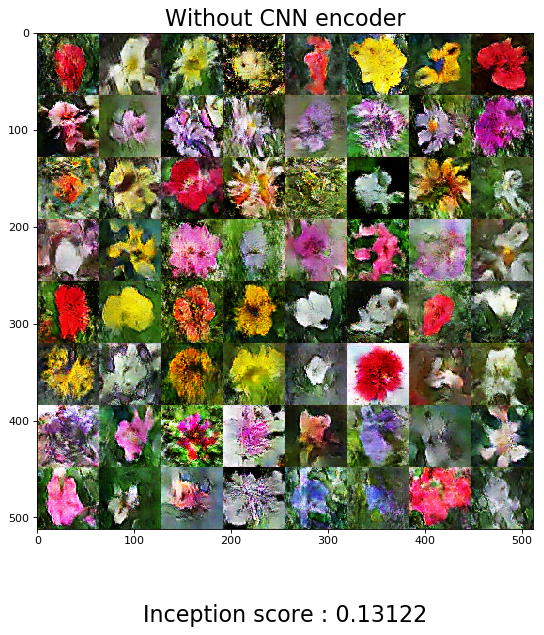

In [12]:
img = Image.open('D:/DL4/samples/train_300.png')
figure(num=None, figsize=(8, 16), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('\n\nInception score : 0.13122', fontsize=20)
plt.title('Without CNN encoder', fontsize=20)
plt.imshow(img)

#### The quality of these flowers is not bad. But the color is a mess.

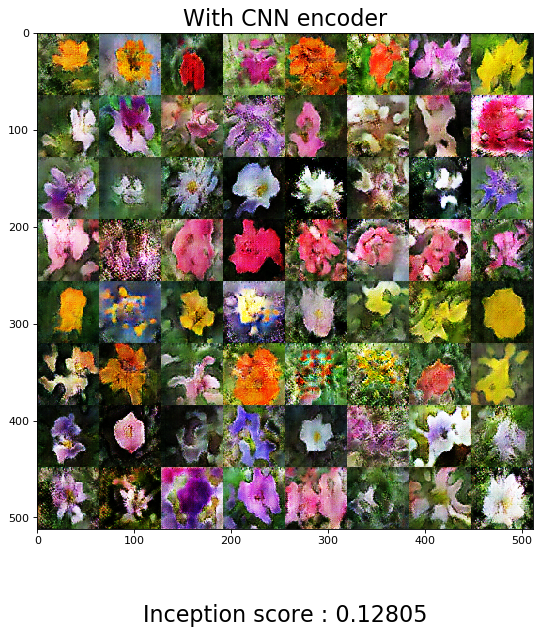

In [13]:
img = Image.open('D:/DL4/samples4/train_295.png')
figure(num=None, figsize=(8, 16), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('\n\nInception score : 0.12805', fontsize=20)
plt.title('With CNN encoder', fontsize=20)
plt.imshow(img)

#### The color  just slightly match with the caption and the quality is not as good as the previous one. However it performs better score.

### 3. Demo ( testing data )

#### The final model we choose has CNN encoder and gradient panelty.

In [27]:
def get_hparas():
    hparas = {
        'MAX_SEQ_LENGTH' : 20,
        'EMBED_DIM' : 300, 
        'VOCAB_SIZE' : len(vocab),
        'TEXT_DIM' : 64, 
        'RNN_HIDDEN_SIZE' : 64,
        'Z_DIM' : 64, 
        'IMAGE_SIZE' : [64, 64, 3], 
        'BATCH_SIZE' : 25,
        'LR' : 0.002,
        'DECAY_EVERY' : 50,
        'LR_DECAY' : 0.5,
        'BETA' : 0.5, 
        'N_EPOCH' : 300,
        'N_SAMPLE' : num_training_sample,
        'GP_LAMBDA' : 0.1,
        'N_CRITICS': 5
    }
    return hparas

In [19]:
tf.reset_default_graph()
BATCH_SIZE = 25
iterator_train, types, shapes = data_iterator(
    data_path + '/text2ImgData.pkl', BATCH_SIZE, training_data_generator)
iter_initializer = iterator_train.initializer
next_element = iterator_train.get_next()

with tf.Session() as sess:
    sess.run(iterator_train.initializer)
    next_element = iterator_train.get_next()
    wrong, image, text = sess.run(next_element)

In [20]:
tf.reset_default_graph()
checkpoint_path = 'D:/DL4/checkpoint4/'
inference_path = 'D:/DL4/inference4'
gan = GAN(get_hparas(), training_phase=True, dataset_path=data_path, ckpt_path=checkpoint_path, inference_path=inference_path, recover=295)

INFO:tensorflow:Restoring parameters from D:/DL4/checkpoint4/cnn_model_295.ckpt
INFO:tensorflow:Restoring parameters from D:/DL4/checkpoint4/rnn_model_295.ckpt
INFO:tensorflow:Restoring parameters from D:/DL4/checkpoint4/g_model_295.ckpt
INFO:tensorflow:Restoring parameters from D:/DL4/checkpoint4/d_model_295.ckpt
-----success restored checkpoint--------


#### Randomly choose 5 testing captions and and generate 5 images with different z respectively.

In [25]:
data_path = 'D:/DL4/dataset'
test_data = pd.read_pickle(data_path + '/testData.pkl')
test_captions = test_data.sample(5)['Captions'].reset_index(drop = True)

def id2sentence(sentence):
    
    if '5427' in sentence :
        
        sentence = sentence[0:sentence.index('5427')]
    
    return ' '.join([id2word_dict[id] for id in sentence])

test_demo = []
for i in range(0, 5):
    test_demo.append(id2sentence(test_captions[i]))

test_demo

['this is a flower that has round shaped orange petals on it',
 'this flower has light pink petals that face upwards and curve around the ovule',
 'these flowers has bright purple flower with a dark purple center and a light purple stem',
 'a bright orange colored cluster of blooms on a long green and burgundy colored stem',
 'this flower has numerous stamen ringed by multiple layers of thin pink petals']

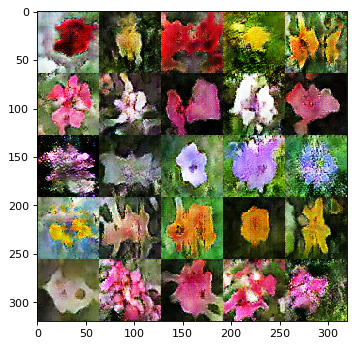

In [26]:
gan._show_testing_image(test_demo)

### 4. What have we tried

- Down size the noise dim to 32 (half of text dim). The outcome didn't change a lot. The inception score is around 0.130.
- We tried label smoothing on dicriminator : 0.8 * tf.onelike. The inception score is also around 0.130.
- We modify the loss to  : dloss1 + (dloss2 + dloss3) * 0.5 + gp. The inception score is around 0.129.